In [2]:
#script to compute cross sections of density, and tends of T&S -- start with Density
import numpy as np
import xarray as xr
import glob
import gzip
import os

%pylab inline
pylab.rcParams['figure.figsize'] = (16,12) # Large figures
pylab.rcParams['image.cmap'] = 'seismic'
dpi=200;

### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

Populating the interactive namespace from numpy and matplotlib


In [3]:
#constants
cp = 3996.0
Lf = 3.337E5
rho_sw = 1026.

In [4]:
#load files
isArchived = True
path = '/lcrc/group/e3sm/ac.afroberts/E3SM_simulations/20210516.v2rc1a.Frazil2.ne30pg2_EC30to60E2r2.chrysalis'
#path = '/lcrc/group/e3sm/ac.golaz/E3SM_simulations/20210324.v2beta3.piControlGM900_GWDfix.ne30pg2_EC30to60E2r2.chrysalis'
#path = '/lcrc/group/e3sm/ac.vanroekel/scratch/anvil/20210414_highFrequencyOutput_EC30to60E2r2'
relPath = 'run'
relPathLogs = 'run'
if isArchived:
    relPath = 'archive/ocn/hist'
    relPathLogs = 'archive/logs'
fnames = '*mpaso.hist.am.timeSeriesStatsMonthly.*'
files = sorted(glob.glob(f'{path}/{relPath}/{fnames}'))

In [5]:
fl = 'cpl.log.*'
cpllist = sorted(glob.glob(f'{path}/{relPathLogs}/{fl}'))

In [6]:
#parse heat budget
hterms = ['hfreeze','hmelt','hnetsw','hlwdn','hlwup','hlatvap','hlatfus','hiroff','hsen','hh2otemp','hsum']
htermVals = []
dateStamps = []
for ij in range(len(cpllist)):
    if cpllist[ij][-2:] == 'gz':
        with gzip.open(cpllist[ij],'rt') as f:
            content = f.read()
            contentSplit = content.split('\n')
    else:
        f = open(cpllist[ij])
        contentSplit = f.readlines()
        
    i=0
    while i < len(contentSplit):
        while 'NET HEAT BUDGET' not in contentSplit[i] or 'monthly' not in contentSplit[i]  :
            i+=1
            if i == len(contentSplit):
                break
        if i < len(contentSplit):
            date = contentSplit[i].split()[-2]
            yr = int(date[:len(date)-4])
            mn = int(date[len(date)-4:len(date)-2])-1
            dateStamp = '{0:04d}-{1:02d}'.format(yr,mn)
            dateStamps.append(dateStamp)
            fInd = [j for j in files if dateStamp in j]
            i += 2

            addArray = np.zeros(len(hterms))

            for ii in range(len(hterms)):
                addArray[ii] = float(contentSplit[i+ii].split()[4])
            htermVals.append(addArray)
            i+=1

In [7]:
#parse water budget
ij=1
wterms = ['wfreeze','wmelt','wrain','wsnow','wevap','wrunoff','wfrzrof','wsum']
wtermVals = []

for ij in range(len(cpllist)):
    if cpllist[ij][-2:] == 'gz':
        with gzip.open(cpllist[ij],'rt') as f:
            content = f.read()
            contentSplit = content.split('\n')
    else:
        f = open(cpllist[ij])
        contentSplit = f.readlines()
        
    i=0
    while i < len(contentSplit):
        while 'NET WATER BUDGET' not in contentSplit[i] or 'monthly' not in contentSplit[i]:
            i+=1
            if i == len(contentSplit):
                break
        if i < len(contentSplit):
       
            i += 2

            addArray = np.zeros(len(wterms))

            for ii in range(len(wterms)):
                addArray[ii] = float(contentSplit[i+ii].split()[4])
            wtermVals.append(addArray)
            i+=1


In [8]:
me = xr.open_dataset('/lcrc/group/e3sm/public_html/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc')
area = me.areaCell.values
glbA = np.sum(area)
landArea = 0.29348259  #Taken from the coupler log under AREA BUDGET
ocnFrac = 1.0 - landArea

In [9]:
# choose a time slices to analyze (for now goes from begining to nYears)
nYears = 20

In [10]:
#now load in mpas variables
# hfreeze - values of seaIceHeatFlux where greater than zero AND frazil (frazilTemperatureTendency*rho_sw*cp)
# hmelt - values of seaIceHeatFlux where less than zero
# hnetsw - total incoming shortwave -- shortWaveHeatFLux
# hlwdn and hlwup - longwaveHeatFluxDown (Up)
# hlatvap - evaporationFlux*Lv or latentHeatFlux
# hlatfus - snowFlux*Lf
# hiroff - iceRunoffFlux*Lf
# hSen - sensibleHeatFlux
# Things not tracked in coupler (yet)
# riverRunoffFlux * max(sst,0)
# seaIceFreshwaterFlux*freezingTemperature
# rainFlux*SST + evaporationFlux*SST
# the last three are calculated as the sum of the first set (no SW) - netFlux from MPAS
htermValsMPAS = np.zeros((len(files),11))

#Water budget
#wfreeze - negative seaice freshwater flux + frazil
#wmelt - positive seaice freshwater flux
#wrain = rainFlux
#wsnow = snowFlux
#wevap - evaporationFlux
#runoff - riverRunoffFlux
#frzrof - iceRunoffFlux
wtermValsMPAS = np.zeros((len(files),8))

for ii in range(min(len(files),nYears*12)):
    ds = xr.open_dataset(files[ii])
    
    #load variables - heat budget terms
    siHF = ds.timeMonthly_avg_seaIceHeatFlux[0,:].values
    fraz = ds.timeMonthly_avg_frazilTemperatureTendency[0,:,:].values
    frazT = np.sum(fraz,axis=1)
    fraz = ds.timeMonthly_avg_frazilLayerThicknessTendency[0,:,:].values
    frazThick = np.sum(fraz,axis=1)
    sw = ds.timeMonthly_avg_shortWaveHeatFlux[0,:].values
    lwup = ds.timeMonthly_avg_longWaveHeatFluxUp[0,:].values
    lwdn = ds.timeMonthly_avg_longWaveHeatFluxDown[0,:].values
    lat = ds.timeMonthly_avg_latentHeatFlux[0,:].values
    latfus = -ds.timeMonthly_avg_snowFlux[0,:].values*Lf
    iroff = -ds.timeMonthly_avg_iceRunoffFlux[0,:].values*Lf
    sen = ds.timeMonthly_avg_sensibleHeatFlux[0,:].values
    siHflux = ds.timeMonthly_avg_seaIceHeatFlux[0,:].values
    
    #load water budget terms
    siFW = ds.timeMonthly_avg_seaIceFreshWaterFlux[0,:].values
    rain = ds.timeMonthly_avg_rainFlux[0,:].values
    evap = ds.timeMonthly_avg_evaporationFlux[0,:].values
    rof = ds.timeMonthly_avg_riverRunoffFlux[0,:].values
    ice = ds.timeMonthly_avg_iceRunoffFlux[0,:].values
    snow = ds.timeMonthly_avg_snowFlux[0,:].values

    if 'timeMonthly_avg_totalFreshWaterTemperatureFlux' in ds.variables:
        freshWaterHeatFlux = ds.timeMonthly_avg_totalFreshWaterTemperatureFlux[0,:].values*rho_sw*cp
    else:
    # if variable not available, approximate the p-e flux associated with heat, not exact as this is a monthly avg
    #note this is missing icebergFlux which is zero for WC sims  Should be replaced with the totalFreshwaterTempFlux variable
        netFlux = cp*rho_sw*ds.timeMonthly_avg_activeTracersSurfaceFlux_temperatureSurfaceFlux[0,:].values
        runoff = cp*rho_sw*ds.timeMonthly_avg_activeTracersSurfaceFluxRunoff_temperatureSurfaceFluxRunoff[0,:].values
    
        freshWaterHeatFlux = netFlux - lat - sen - lwup - lwdn - siHflux - latfus - iroff
        #add runoff contribution
        freshWaterHeatFlux += runoff
    
    #heat budget calculations
    iceInds = np.where(siHF > 0)[0]
    frazInds = np.where(frazT)
    htermValsMPAS[ii,0] = ocnFrac*(np.sum(siHF[iceInds]*area[iceInds])/glbA \
                                   + np.sum(area*frazT*rho_sw*cp)/glbA)
    
    iceInds = np.where(siHF < 0)[0]
    htermValsMPAS[ii,1] = ocnFrac*np.sum(siHF[iceInds]*area[iceInds])/glbA

    htermValsMPAS[ii,2] = ocnFrac*np.sum(sw*area)/glbA
    htermValsMPAS[ii,3] = ocnFrac*np.sum(lwdn*area)/glbA
    htermValsMPAS[ii,4] = ocnFrac*np.sum(lwup*area)/glbA
    htermValsMPAS[ii,5] = ocnFrac*np.sum(lat*area)/glbA
    htermValsMPAS[ii,6] = ocnFrac*np.sum(latfus*area)/glbA
    htermValsMPAS[ii,7] = ocnFrac*np.sum(iroff*area)/glbA
    htermValsMPAS[ii,8] = ocnFrac*np.sum(sen*area)/glbA
    htermValsMPAS[ii,9] = ocnFrac*np.sum((freshWaterHeatFlux)*area)/glbA 
    htermValsMPAS[ii,10] = np.sum(htermValsMPAS[ii,:10])
    
    #water budget calculations
    wtermValsMPAS[ii,0] = ocnFrac*rho_sw*(np.sum(frazThick*area)/glbA)
    wtermValsMPAS[ii,1] = ocnFrac*(np.sum(siFW*area)/glbA)

    wtermValsMPAS[ii,2] = ocnFrac*np.sum(rain*area)/glbA
    wtermValsMPAS[ii,3] = ocnFrac*np.sum(snow*area)/glbA
    wtermValsMPAS[ii,4] = ocnFrac*np.sum(evap*area)/glbA
    wtermValsMPAS[ii,5] = ocnFrac*np.sum(rof*area)/glbA
    wtermValsMPAS[ii,6] = ocnFrac*np.sum(ice*area)/glbA
    wtermValsMPAS[ii,7] = wtermValsMPAS[ii,:7].sum()
    
    ds.close()

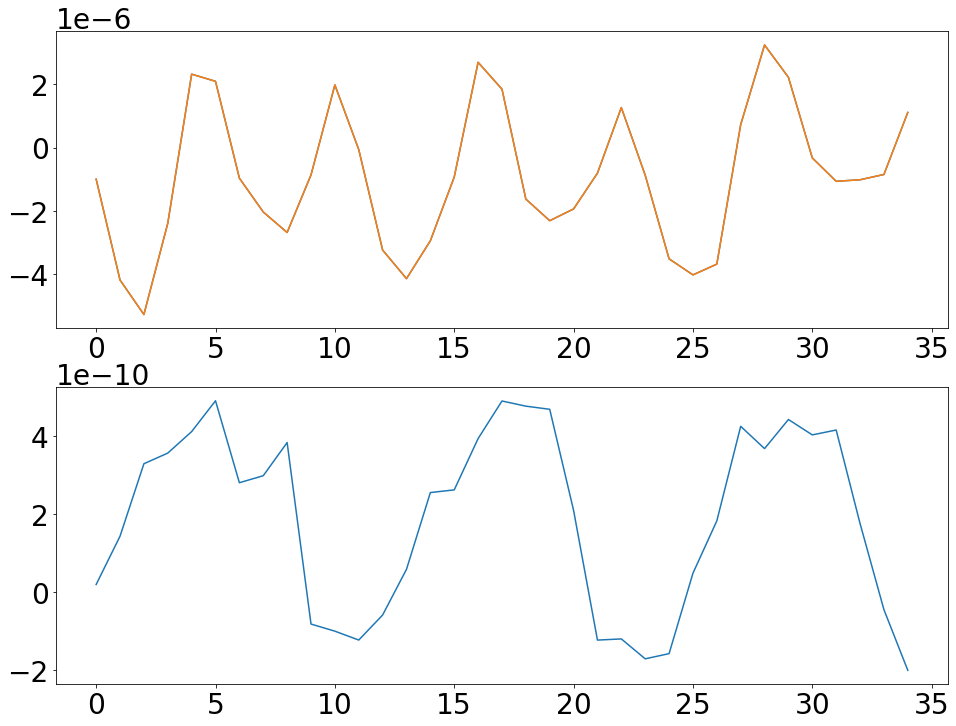

In [11]:
fig,ax = plt.subplots(2,1)
ax[0].plot(wtermValsMPAS[1:36,-1])
hcpl = np.asarray(wtermVals)*1e-6
ax[0].plot(hcpl[1:36,-1])
ax[1].plot(wtermValsMPAS[1:36,-1]-hcpl[1:36,-1])

In [50]:
#chose specific entry to put in table -- it is by month from start of run
ii=2
from tabulate import tabulate
tab = []
for i in range(len(hterms)):
    tab.append([hterms[i],htermVals[ii][i],htermValsMPAS[ii,i]])

print('Heat Budget (W/m^2) for -- '+dateStamps[ii])
print(' ')
print(tabulate(tab,headers=['Field','Coupler','MPAS-Ocean']))

Heat Budget (W/m^2) for -- 0001-03
 
Field          Coupler    MPAS-Ocean
--------  ------------  ------------
hfreeze      0.163238      0.163293
hmelt       -0.849968     -0.849969
hnetsw     128.674       128.674
hlwdn      241.785       241.785
hlwup     -278.561      -278.561
hlatvap    -76.9762      -76.9762
hlatfus     -0.393207     -0.393207
hiroff      -0.0936651    -0.0936652
hsen       -10.9026      -10.9026
hh2otemp    -0.591192     -0.591306
hsum         2.2548        2.25474


In [51]:
#chose specific entry to put in table
ii=10
from tabulate import tabulate
tab = []
for i in range(len(wterms)):
    tab.append([wterms[i],wtermVals[ii][i],1e6*wtermValsMPAS[ii,i]])
    
print(r'Water Budget (1e6 kg m$^{-2}$s$^{-1}$) for -- '+dateStamps[ii])
print(' ')
print(tabulate(tab,headers=['Field','Coupler','MPAS-Ocean']))

Water Budget (1e6 kg m$^{-2}$s$^{-1}$) for -- 0001-11
 
Field       Coupler    MPAS-Ocean
-------  ----------  ------------
wfreeze   -0.398042     -0.398314
wmelt      2.78137       2.78137
wrain     24.5214       24.5214
wsnow      0.8581        0.8581
wevap    -30.1741      -30.1741
wrunoff    0.939957      0.939957
wfrzrof    0.201255      0.201255
wsum      -1.27008      -1.27036


In [23]:
ij=2
if isArchived:
    dirs=sorted(os.listdir(f'{path}/archive/rest'))
    s2 = dirs[ij].rfind('-000')
    searchString1 = dirs[ij][:s2]
    searchString2 = dirs[ij+1][:s2]
    fs = sorted(os.listdir(f'{path}/archive/rest/{dirs[ij]}'))
    res1 = [j for j in fs if 'mpaso.rst' in j][0]
    resFile1 = f'{path}/archive/rest/{dirs[ij]}/{res1}'
    fs = sorted(os.listdir(f'{path}/archive/rest/{dirs[ij+1]}'))
    res2 = [j for j in fs if 'mpaso.rst' in j][0]
    resFile2 = f'{path}/archive/rest/{dirs[ij+1]}/{res2}'
    
else:
    resNames = '*mpaso.rst.0*'
    resFiles = sorted(glob.glob(f'{path}/{relPath}/{resNames}'))
    s=resFiles[0].rfind('rst.')
    s2 = resFiles[0].rfind('_000')
    searchString1 = resFiles[ij][s+4:s2]
    searchString2 = resFiles[ij+1][s+4:s2]
    resFile1 = resFiles[ij]
    resFile2 = resFiles[ij+1]

In [24]:
#for storage go between restarts and sum the terms in the budget
#find a list of restarts
#grab 2, parse dates and find monthly averages in between and sum

#choose spot to analyze (must be in the restart files, need at least two for this to work, this example
# shows how to analyze the change between the 3 and 4 restart files)
f1 = [j for j in range(len(files)) if searchString1 in files[j]]
f2 = [j for j in range(len(files)) if searchString2 in files[j]]
nyears = (f2[0]-f1[0])/12
ds1 = xr.open_dataset(resFile1)
ds2 = xr.open_dataset(resFile2)

lt1 = ds1.layerThickness[0,:,:].values
t1 = ds1.temperature[0,:,:].values

lt2 = ds2.layerThickness[0,:,:].values
t2 = ds2.temperature[0,:,:].values

dHeat = cp*rho_sw*(lt2*t2 - lt1*t1)/(nyears*365*86400.)

ssh1 = ds1.layerThickness[0,:,:].sum(axis=1).values - ds1.bottomDepth.values
ssh2 = ds2.layerThickness[0,:,:].sum(axis=1).values - ds2.bottomDepth.values
dSSH = (ssh2*area - ssh1*area) / (nyears*365*86400.)

In [25]:
#for the tends try with the actual seconds in month, make an array and duplicate nyears time to get mC/s so 
#divide by rho_cp first and multiply by seconds in month then divide by 5 years to get back and multiply in 
#rho_cp
secs = np.asarray([31,28,31,30,31,30,31,31,30,31,30,31])*86400
totalSecs = np.tile(secs,int(nyears))
#total heat flux is untracked + sum
totalFlux = (htermValsMPAS[f1[0]:f2[0],-1])/ocnFrac
sumHFlux = np.sum(totalSecs*totalFlux)/np.sum(totalSecs)

totalFlux = (wtermValsMPAS[f1[0]:f2[0],-1])/ocnFrac/rho_sw
sumWFlux = np.sum(totalSecs*totalFlux)/np.sum(totalSecs)

In [26]:
print('MPAS SSH change over {} years = {}, Calculated Tendency = {}'.format(nyears,dSSH.sum()/glbA,sumWFlux))

MPAS SSH change over 5.0 years = -3.2030112557678543e-11, Calculated Tendency = -3.203011233614065e-11


In [27]:
dSSH.sum()/glbA-sumWFlux

-2.215378962605615e-19

In [17]:
print('MPAS heat change over {} years = {}, Calculated Tendency = {}'\
      .format(nyears,np.sum(np.sum(dHeat,axis=1)*area)/np.sum(area),sumHFlux))

MPAS heat change over 5.0 years = 0.3722087240760307, Calculated Tendency = 0.3719850923940803
